Installing some standard libraries

Just hitting run all will do all the set up, and then start training new models. Thus, we do not reccomend this. We reccommend following these in order until the section Monolingual Models. These should probably be replaced with implementation following Bloem 2020. 
To further analyze our work as shown in the paper, jump to section "Loading the Aligned Vectors" after running everything up to Monolingual Models. 

In [ ]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install gensim
!pip install faiss-gpu

     |████████████████████████████████| 90.1 MB 25 kB/s 


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import glob
import random
import time
import pickle
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from pathlib import Path

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2

from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import RegexpTokenizer

import string
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!pip install fastText

     |████████████████████████████████| 68 kB 5.2 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3127024 sha256=277eb439edfa0f1a0b523cfb3cf390653fff462d04c8cc0ca456f6956c61ceed
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fastText


In [ ]:
import fasttext

Connecting to drive, which held our files.

In [ ]:
import sys
import os
from google.colab import drive

# enable use of google drive
drive.mount('/content/drive', force_remount=True)

# set the working directory
% cd /content/drive/MyDrive/CS325CFinal
# link to project directory
project_folder = "/content/drive/MyDrive/CS325CFinal"

# clean of previous directories from sys
while(True):
  try:
    sys.path.remove(project_folder)
  except ValueError:
    break
# append new path
sys.path.append(project_folder)

#!ls "/content/drive/MyDrive/CS325CFinal"

Mounted at /content/drive
/content/drive/MyDrive/CS325CFinal


Building the C++ command line version of FastText, because that is what MUSE needs. The python module seemed like it would be enough at first

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

This was a little preprocessing script that got all our data into its preprocessed forms. Mainly, it removes spaces and punctuation, and makes everything lower case. However, we observed some quotation marks mysteriously remain in our data. We provide both the original files and the final pre-processed ones. 

In [ ]:

def preprocess(file, new_name):
  myfile = open(file)
  text = myfile.read()

  #remove whitespaces
  text = text.strip()
  # remove numbers
  text_nonum = re.sub(r'\d+', '', text)
  # remove punctuations and convert characters to lower case
  text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
  # substitute multiple whitespace with single whitespace
  # Also, removes leading and trailing whitespaces
  cleaned_text = re.sub('\s+', ' ', text_nopunct).strip()

  #cleaned_text = clean_text(text)
  tokens = nltk.word_tokenize(cleaned_text)
  # tokenizer = RegexpTokenizer('\w+')
  # tokens = tokenizer.tokenize(text)
  #print(tokens)
  print(file)
  print(new_name)
  print(cleaned_text[0:100])
  my_new_file = open(new_name, 'w')
  my_new_file.write(cleaned_text)
  return 1
preprocess('LemmatizedAeneid.txt','preprocessed_LemmatizedAeneid.txt')




LemmatizedAeneid.txt
preprocessed_LemmatizedAeneid.txt
﻿arma vir que cano troia qui primus a ora italia fatum profugus lavinius que venio litus multum ille


1

In [ ]:
! head -c 80 preprocessed_LemmatizedAeneid.txt

﻿arma vir que cano troia qui primus a ora italia fatum profugus lavinius que v

# Monolingual Models
The actual training of the monolingual models. These were fairly fast to train at least, but need more quality control. 

In [ ]:
model_LemLat = fasttext.train_unsupervised('preprocessed_LemmatizedAeneid.txt', lr=0.25, minCount=1, dim=300, lrUpdateRate=20)

In [ ]:
model_LemLat_no_subwords = fasttext.train_unsupervised('preprocessed_LemmatizedAeneid.txt', lr=0.25, minCount=1, maxn=0, dim=300, lrUpdateRate=20)

In [ ]:
model_LemLat_no_subwords.get_nearest_neighbors("imperium", 15)

In [ ]:
model_LemLat.get_nearest_neighbors("imperium", 15)

In [ ]:
model_LemLat.get_subwords("imperium")

In [ ]:
model_Lat1 = fasttext.train_unsupervised('preprocessed_Aeneid.txt', epoch=5, lr=0.25, minCount=1, minn=2, maxn=4, dim=300, lrUpdateRate=80) 

In [ ]:
model_Lat1.get_subwords("imperium")

In [ ]:
model_Lat1.get_nearest_neighbors("imperium", 15)

[(0.8568574786186218, 'imperitet'),
 (0.8178245425224304, 'hesperium'),
 (0.8104792833328247, 'periclum'),
 (0.8069432973861694, 'imperiumque'),
 (0.8036075234413147, 'imperio'),
 (0.8006677627563477, 'imperiis'),
 (0.800383985042572, 'ilium'),
 (0.7843039631843567, 'impetus'),
 (0.7756040692329407, 'invisum'),
 (0.7747954726219177, 'idalium'),
 (0.7723197340965271, 'iulum'),
 (0.7680293321609497, 'iugum'),
 (0.7674857378005981, 'iūdicium'),
 (0.7649470567703247, 'italum'),
 (0.7631957530975342, 'impexum')]

In [ ]:
model_Dryden = fasttext.train_unsupervised('preprocessed_Aeneid_Dryden.txt', lr=0.15, dim=300) 

In [ ]:
model_Conington =  fasttext.train_unsupervised('preprocessed_Aeneid_Conington.txt', lr=0.15, dim=300)

In [ ]:
model_Williams = fasttext.train_unsupervised('preprocessed_Aeneid_Williams.txt', lr=0.15, dim=300)

In [ ]:
model_Dryden.get_nearest_neighbors("empire")

[(0.7299820780754089, 'severe'),
 (0.7279876470565796, 'subjects'),
 (0.7255538105964661, 'carthage'),
 (0.670727014541626, 'latium'),
 (0.6638401746749878, 'level'),
 (0.6592938303947449, 'endure'),
 (0.6486359238624573, 'labours'),
 (0.6404553055763245, 'founder'),
 (0.6398696899414062, 'law'),
 (0.6379755735397339, 'labour')]

In [ ]:
model_Williams.get_nearest_neighbors("empire")

[(0.9896291494369507, 'dire'),
 (0.9894116520881653, 'tidings'),
 (0.9887881875038147, 'slumber'),
 (0.9876969456672668, 'altar'),
 (0.9876559376716614, 'bare'),
 (0.987324059009552, 'greeks'),
 (0.986694872379303, 'altars'),
 (0.9862745404243469, 'lay'),
 (0.9860420823097229, 'array'),
 (0.9859839081764221, 'obedient')]

In [ ]:
model_Conington.get_nearest_neighbors("empire")

[(0.7962254285812378, 'assume'),
 (0.7266069650650024, 'dardanus'),
 (0.7224622368812561, 'oracles'),
 (0.7200887203216553, 'aspire'),
 (0.7183236479759216, 'employ'),
 (0.7173357009887695, 'twere'),
 (0.7120724320411682, 'waits'),
 (0.7109524607658386, 'waged'),
 (0.7105631828308105, 'nymphs'),
 (0.7037217020988464, 'implore')]

In [ ]:
model_Conington.get_nearest_neighbors("dido")

[(0.9999708533287048, 'didos'),
 (0.9999435544013977, 'realms'),
 (0.9999420046806335, 'undone'),
 (0.9999416470527649, 'relics'),
 (0.9999404549598694, 'olympian'),
 (0.9999383091926575, 'grateful'),
 (0.9999381303787231, 'phrase'),
 (0.9999374747276306, 'diomed'),
 (0.9999366998672485, 'lavinia'),
 (0.9999354481697083, 'palinure')]

In [ ]:
!cd MUSE-main/
!ls

/bin/bash: line 0: cd: MUSE-main/: No such file or directory
sample_data


#Saving the models

In [ ]:
#Save models as binaries
model_Dryden.save_model("MUSE-main/data/Dryden.bin")
model_Conington.save_model("MUSE-main/data/Conington.bin")
model_Williams.save_model("MUSE-main/data/Williams.bin")
model_Lat1.save_model("MUSE-main/data/Lat1.bin")
model_LemLat.save_model("MUSE-main/data/LemLat.bin")

In [ ]:
import fasttext

#Linking the models with MUSE
which is Chen 2018

In [ ]:
!python  MUSE-main/unsupervised.py --src_lang en_Dyrden --tgt_lang latin --src_emb MUSE-main/data/Dryden.bin --tgt_emb MUSE-main/data/LemLat.bin --n_refinement 5
!python  MUSE-main/unsupervised.py --src_lang en_Conington --tgt_lang latin --src_emb MUSE-main/data/Conington.bin --tgt_emb MUSE-main/data/LemLat.bin --n_refinement 5
!python  MUSE-main/unsupervised.py --src_lang en_Williams --tgt_lang latin --src_emb MUSE-main/data/Williams.bin --tgt_emb MUSE-main/data/LemLat.bin --n_refinement 5
!python  MUSE-main/unsupervised.py --src_lang en_Dyrden --tgt_lang latin --src_emb MUSE-main/data/Dryden.bin --tgt_emb MUSE-main/data/Lat1.bin --n_refinement 5
!python  MUSE-main/unsupervised.py --src_lang en_Conington --tgt_lang latin --src_emb MUSE-main/data/Conington.bin --tgt_emb MUSE-main/data/Lat1.bin --n_refinement 5
!python  MUSE-main/unsupervised.py --src_lang en_Williams --tgt_lang latin --src_emb MUSE-main/data/Williams.bin --tgt_emb MUSE-main/data/Lat1.bin --n_refinement 5


In [ ]:
#from Fasttext's docs: how to load vectors stored in a txt file
import io
def load_vec(emb_path, nmax=5000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

We ran several experiments. The ones used to show results in the paper are in:
/content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Dryden-LemLat/
/content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Williams-LemLat/
/content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Conington-LemLat/

In [ ]:
!ls /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Dryden-LemLat/

best_mapping.pth  train.log		 vectors-latin.txt
params.pkl	  vectors-en_Dryden.txt


#loading the algined vectors
Start here if you want to do further evaluation on what we already have

In [ ]:
src_path = '/content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Dryden-LemLat/vectors-en_Dryden.txt'
tgt_path = '/content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Dryden-LemLat/vectors-latin.txt'
nmax = 5000 # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [ ]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [ ]:
src_word = 'honor'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "voice":
1.0000 - voice
0.8797 - choice
0.8343 - went
0.8183 - nurse
0.8077 - content


In [ ]:
# printing nearest neighbors in the target space
src_word = 'honor'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=10)

Nearest neighbors of "sleep":
0.7088 - mugitus
0.6686 - ritus
0.6608 - spiritus
0.6466 - subitus
0.6248 - interritus
0.5981 - tinnitus
0.5676 - imperterritus
0.5652 - obitus
0.5535 - digitus
0.5505 - turritus


auto quantitative evaluations with knn. 

In [ ]:
!python MUSE-main/evaluate.py --src_lang en_Conington --tgt_lang Latin --src_emb /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Conington-LemLat/vectors-en_Conington.txt --tgt_emb /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Conington-LemLat/vectors-latin.txt --max_vocab 5000 --dico_eval /content/drive/MyDrive/CS325CFinal/crosslingual/dictionaries/1_en-latin.txt

In [ ]:
!python MUSE-main/evaluate.py --src_lang en_Williams --tgt_lang Latin --src_emb /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Williams-LemLat/vectors-en_Williams.txt --tgt_emb /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Williams-LemLat/vectors-latin.txt --max_vocab 5000 --dico_eval /content/drive/MyDrive/CS325CFinal/crosslingual/dictionaries/1_en-latin.txt

In [ ]:
!python MUSE-main/evaluate.py --src_lang en_Dryden --tgt_lang Latin --src_emb /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Dryden-LemLat/vectors-en_Dryden.txt --tgt_emb /content/drive/MyDrive/CS325CFinal/MUSE-main/dumped/debug/debug/Dryden-LemLat/vectors-latin.txt --max_vocab 5000 --dico_eval /content/drive/MyDrive/CS325CFinal/crosslingual/dictionaries/1_en-latin.txt

Very nice stuff for the visualization

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.16


In [ ]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

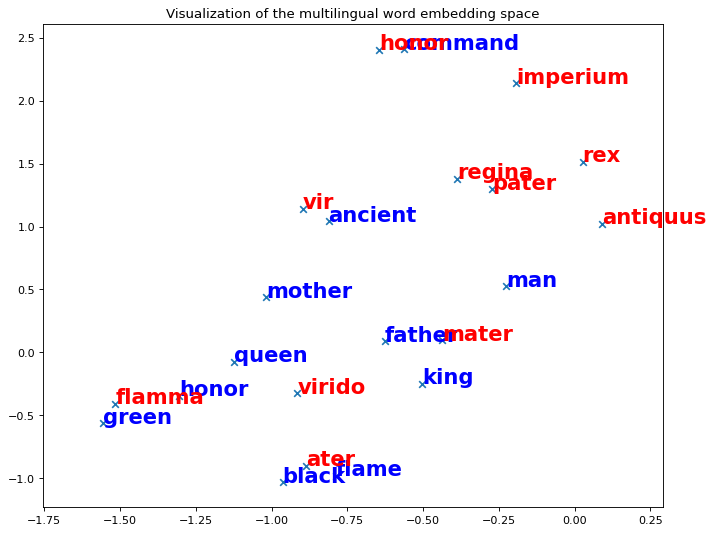

In [ ]:
# get 5 random input words
src_words = ['flame', 'honor', 'black', 'ancient','command', 'green', 'man', 'mother', 'father', 'king', 'queen']
tgt_words = ['flamma', 'honor', 'ater', 'antiquus', 'imperium', 'virido', 'vir', 'mater', 'pater', 'rex', 'regina']


# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)